In [2]:
from covid_project.data_utils import clean_covid_data, clean_policy_data
from covid_project.data_utils import get_cases, get_policies, clean_policy_data

import seaborn as sns
import pandas as pd
import datetime
import matplotlib.pyplot as plt 
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from matplotlib.patches import Patch
import seaborn as sns

BIG_FONT   = 18
MED_FONT   = 14
SMALL_FONT = 10

In [3]:
case_data = clean_covid_data()
policy_data = clean_policy_data()

In [44]:
def plot_cases(case_data=None,
               level="county", 
               county="orange", 
               state="California", 
               fade=0.75, 
               style="whitegrid", 
               ax=None, 
               fig=None, 
               save_figure=False, 
               fig_size=(10, 5), 
               filename="Plot cases figure.png",
               ret=False,
               date_range = ["2020-01-01", "2020-12-31"]):
    
    """ A function which plots the COVID-19 case/death data and 7 day average.
    
    Parameters
    ---------- 
    case_data: pandas DataFrame 
        DataFrame for plotting 
    level: {'county', 'state', 'national'}
        Value to pass to get_cases() 
        Default: "county"
    county: string 
        desired county
        Default: "orange"
    state: string 
        desired state
        Default: "California"
    fade: float
        level of transparency for new_cases_1e6 and new_deaths_1e6 
        Default: 0.75
    style: string
        Seaborn plot style 
        Default: "whitegrid"
    ax: matplotlib axis object
        Add to an existing axis
    fig: matplotlib figure object
    save_figure: boolean
        Default: False
    fig_size: tuple
    filename: string
        Name of file if saving figure
    ret: boolean
        If true, returns the figure, axes, and data used to generate the plot
    date_range: list
        [start_date, end_date] in "YYYY-mm-dd" format
    Returns 
    ----------
    matplotlib.figure.Figure
    ndarray containing the two axis handles
    pandas DataFrame
    """
    # get the data
    if case_data is None:
        raise NotImplementedError

    # Get the data. 
    cases = get_cases(case_dataframe=case_data,
                      level=level,
                      county=county,
                      state=state)
    
    # filter to date range
    cases = cases[(cases.index > pd.to_datetime(date_range[0])) &\
                  (cases.index < pd.to_datetime(date_range[1]))]
        
    # Set up plots. 
    if ax is None: 
        fig, ax = plt.subplots(2, 1, figsize=fig_size, sharex=True);
    plt.subplots_adjust(hspace=0.02)
    sns.set_style(style)
    
    # Plot cases.
    cases.plot(
        color=[f'{fade}', 'k'],
        y=["new_cases_1e6","new_cases_7day_1e6"],
        label=["Cases per capita", "7-day average"],
        ax=ax[0]
        );

    # Plot deaths. 
    cases.plot(
        color=[f'{fade}', 'k'],
        y=["new_deaths_1e6","new_deaths_7day_1e6"],
        label=["Deaths per capita", "7-day average"],
        ax=ax[1]
        );
    
    # Format axis labels. 
    ax[0].set_ylabel("cases per 100,000", fontsize=MED_FONT)
    ax[1].set_ylabel("deaths per 100,000", fontsize=MED_FONT)
    
    # Set plot title based on level of aggregeation (county, state, or national)
    if level == "county":
        ax[0].set_title(f"New COVID-19 cases and deaths per 100,000 in {county} County, {state}", fontsize=BIG_FONT-4);
    elif level == "state": 
        ax[0].set_title(f"New COVID-19 cases and deaths per 100,000 in {state}", fontsize=BIG_FONT-4);
    else: 
        ax[0].set_title("New COVID-19 cases and deaths per 100,000 in the United States", fontsize=BIG_FONT-4)
    
    if save_figure: 
        plt.savefig(filename)
    
    if ret:
        return fig, ax, cases

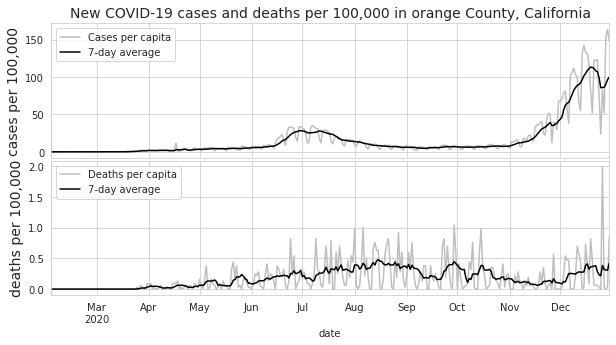

In [45]:
plot_cases(case_data=case_data, date_range=["2020-02-02", "2020-12-31"])

<Figure size 432x288 with 0 Axes>

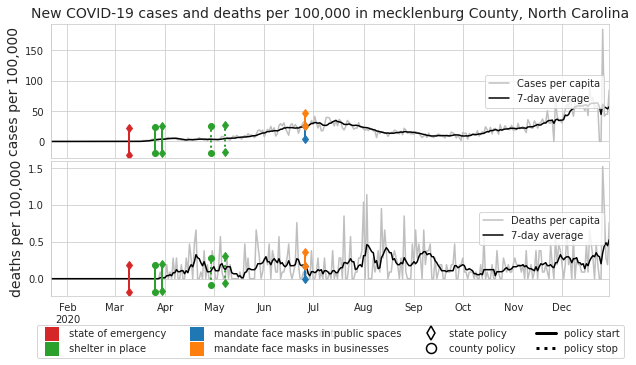

In [46]:
def plot_cases_and_policies(
        county, 
        state,
        case_data,
        policy_data,
        colors=sns.color_palette()[:],
        policies=[
            "mandate face masks in public spaces", 
            "mandate face masks in businesses", 
            "shelter in place", 
            "state of emergency"],
                           
        labels=["face mask mandate (public spaces)", 
            "face mask mandate (businesses)", 
            "shelter in place", 
            "state of emergency"],
        save_figure=False, 
        filename="Plot cases and policies figure.png", 
        fig_size=(10, 5), 
        date_range = ["2020-01-01", "2020-12-31"],
    ):

    
    """Plot the cases overlayed with the policies. 
    
    Parameters
    ---------- 
    county : string 
        county of interest
    state : string
        state of interest
    case_data : data frame containing case data (results of clean_case_data())
    policy_data : data frame containing policy data (results of clean_policy_data())
    colors : array-like
        line colors for respective policies 
    policies : list of policies to plot
    labels : array-like 
        legend labels for the selected policies (default: "face mask mandate (public spaces)", 
        "face mask mandate (businesses)", "shelter in place", and "state of emergency")
    save_figure : boolean
        If true, saves the figure to file
    filename : string
        filename to use for saving the figure
    fig_size : tuple
        size of output figure
    date_range: list
        [start_date, end_date] in "YYYY-mm-dd" format
        
    The marks for policies are aligned with the 7 day average, using colors to indicate policy types, endcaps for 
    state (diamond) or county (circle), and linestyle to distinguish the start (solid line) or stop (dotted line) of a 
    policy. 
    
    Returns
    ----------
    ndarray containing the two axis handles used for plotting
    """
    
    # Plot case / death data.
    plt.figure();
    fig, ax, df = plot_cases(case_data=case_data,
                             level="county",
                             county=county,
                             state=state,
                             fig_size=fig_size,
                             ret = True);

    # Get the policy data for the selected state and county.
    policy_data = get_policies(policy_dataframe=policy_data,
                               state=state,
                               county=county);

    # Set a solid line to be the start of a policy and a dashed line to be the end.
    styles_start_stop = {
        "start" : '-', 
        "stop" : ':'
    }

    # Set color codes for selected policies.
    styles_policy_type = {policies[i] : colors[i] for i in range(len(policies))}
    
    # Set labels for legend.
    legend_policy_labels = {policies[i] : labels[i] for i in range(len(policies))}
    
    # Define plot parameters.  
    line_split = 0                
    mark_length = 0.2
    plot_policies = policy_data[policy_data['policy_type'].isin(policies)]
    labels = []
    
    # Loop through both axes. 
    for i in range(2):
        #print(ax[i].lines[0].get_ydata())
        # Expand y axis to get some extra room on the bottom.
        ax[i].set_ylim(-max(ax[i].lines[0].get_ydata())*(0.15))
        
        # Loop through policies.
        for index, row in plot_policies.sort_values(by="date").iterrows():

            # Get the y-positional coordinate for the line on the selected day (between 0 and 1). 
            if i == 0: 
                center = df[df.index == row.date]['new_cases_7day_1e6'].values[0]
            else: 
                center = df[df.index == row.date]['new_deaths_7day_1e6'].values[0]
            
            # Calculate where to position the line horizontally.  
            row_date = row.date
            #row_date = datetime.datetime.strptime(row_date, "%Y-%m-%d")
            days_serial = (row_date - pd.Timestamp(year=1970, month=1, day=1)).days
            cent_coord = ax[i].transLimits.transform((days_serial, center))[1]
            #print(f"days_serial={days_serial}; cent_coord={cent_coord}")
            # loop through all the policies enacted on a given day. Normally, this is 1, but we want to visualize all the
            # policies enacted on the same day, so we're goint to split the line accordingly.

            num_policies = plot_policies['date'].value_counts()[row.date]
            
            # Split the mark if there are multiple policies enacted on the same day.
            if num_policies > 1: 
                hmin = (cent_coord - (mark_length/2)) + line_split * (mark_length/num_policies)
                hmax = (cent_coord + (mark_length/2)) - \
                    (mark_length/num_policies) + ((line_split*mark_length) / num_policies)
                line_split += 1

            if num_policies == 1:
                hmin = (cent_coord - (mark_length/2))
                hmax = (cent_coord + (mark_length/2))
                line_split=0
                
            # Plot the mark.
            line = ax[i].axvline(x         = row.date,
                                 linestyle = styles_start_stop[row.start_stop], 
                                 color     = styles_policy_type[row.policy_type], 
                                 lw        = 2,
                                 ymin      = hmin, 
                                 ymax      = hmax,
                                )

            # Add the policy to the legend if it's not already in the list of labels
            if (row.policy_type not in labels): 
                labels.append(row.policy_type);
                
            # Set markers for state or county policies. 
            if row.policy_level == "state":
                line.set_marker('d')
                
            else: 
                line.set_marker('o')
                
            ax[i].legend(loc="right")
        # ax[i].set_ylim(-max(ax[i].lines[0].get_ydata())*(0.15))
        
    # Make the legend. 
    legend_lines = []
    
    # Use square boxes to denote colors for policy types. 
    [legend_lines.append(Line2D([0], [0], marker="s", markersize=15, color='w', 
                           markerfacecolor=styles_policy_type[policy], lw=3, label=policy)) for policy in labels]
    
    # Draw a diamond to indicate a state policy. 
    legend_lines.append(Line2D([0], [0], marker="d", markersize=10, color='w', 
                           markerfacecolor='w', markeredgecolor='k', markeredgewidth=1.5, lw=3, label="state policy"))
    
    # Draw a circle to indicate a county policy. 
    legend_lines.append(Line2D([0], [0], marker="o", markersize=10, color='w', 
                           markerfacecolor='w', markeredgecolor='k', markeredgewidth=1.5, lw=3, label="county policy"))
    
    # Use a solid line for policy start, dotted line for policy stop. 
    legend_lines.append(Line2D([0], [0], linestyle='-', color='k', lw=3, label = "policy start"))
    legend_lines.append(Line2D([0], [0], linestyle=':', color='k', lw=3, label = "policy stop"))
                   
     
    # Finally, draw the legend. 
    leg1 = ax[1].legend(loc='right')
    leg2 = ax[1].legend(handles=legend_lines, loc='lower center',  bbox_to_anchor=(0.5, -0.5), ncol=4)
    ax[1].add_artist(leg1);
    
    if save_figure: 
        plt.savefig(filename, bbox_inches='tight')
        
    return fig, ax

plot_cases_and_policies(
    county='mecklenburg',
    state='North Carolina',
    case_data=case_data,
    policy_data=policy_data,
    date_range = ["2020-02-02", "2020-12-31"]
);